In [9]:
from calendar import month, week
from datetime import timedelta, datetime
from tkinter import NS
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from utils.payoff_function import calculate_option_price
from utils.evaluation import evaluate_option_price
from utils.simulation_function import SimMultiGBMAV,SimMultiGBM
from utils.extract_data_function import extract_data
from utils.counting_days_function import days
from utils.ems_correction import EMSCorrection
from utils.calculate_implied_volatility import calculate_cov_matrix
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")

## Simulation

date_to_predict: 2022-08-19 00:00:00
hist_end: 2022-08-18 00:00:00
end_date: 2022-10-21 00:00:00
q2_to_maturity: 127
q3_to_maturity: 65
q2: 2023-02-20 00:00:00
q3: 2023-05-19 00:00:00
total_trading_days: 254
holidays: ['2022-09-05', '2022-11-24', '2022-12-26', '2023-01-01', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-07-04']
trading_days_to_simulate: 254
Derivative Price for 2022-08-19 00:00:00
1001.529623305557
trading_days_to_simulate: 251
Derivative Price for 2022-08-22 00:00:00
983.7173757120637
trading_days_to_simulate: 250
Derivative Price for 2022-08-23 00:00:00
992.9635166452483
trading_days_to_simulate: 249
Derivative Price for 2022-08-24 00:00:00
986.1164616989608
trading_days_to_simulate: 248
Derivative Price for 2022-08-25 00:00:00
1010.7251830679612
trading_days_to_simulate: 247
Derivative Price for 2022-08-26 00:00:00
978.0457707669837
trading_days_to_simulate: 244
Derivative Price for 2022-08-29 00:00:00
981.2278200094088
trading_days_to_simulate: 243
D

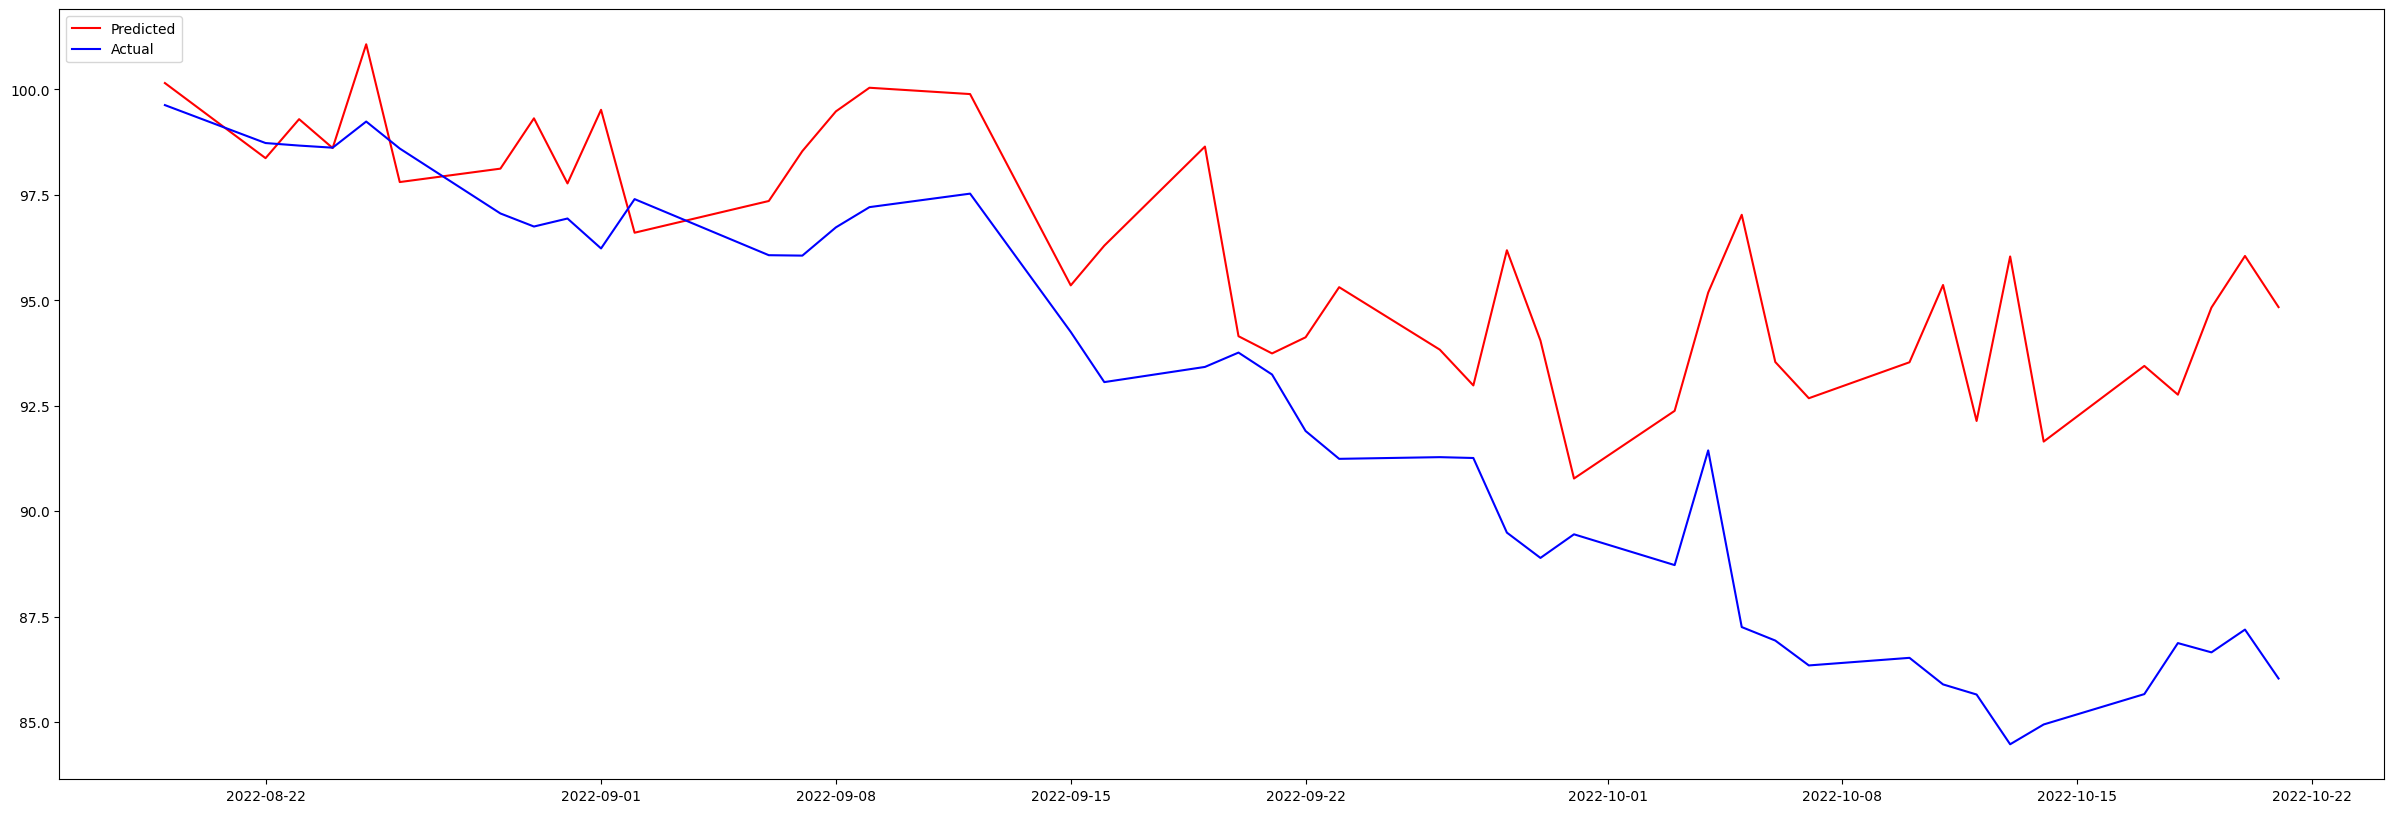

In [25]:
experiment_details = {
    'Nsim': 250,
    'latest_price_date': '2022-10-21',
    'variance_reduction': True,
    'GBM': 'multivariate',
    'r': 0.045,
    'IV': True,
    'min_sigma':0.0001,
    'max_sigma':5,
    'step':0.00001,
    'error':0.25,
    'EMS': True
}

aapl_barrier = 85.760
amzn_barrier = 69.115
googl_barrier = 58.605
aapl_initial = 171.52
amzn_initial = 138.23
google_initial = 117.21

date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
    latest_price_date=experiment_details['latest_price_date'])

print(f"date_to_predict: {date_to_predict}")
print(f"hist_end: {hist_end}")
print(f"end_date: {end_date}")
print(f"q2_to_maturity: {q2_to_maturity}")
print(f"q3_to_maturity: {q3_to_maturity}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"total_trading_days: {total_trading_days}")
print(f"holidays: {holidays}")
trading_days_to_simulate = total_trading_days

if experiment_details['IV']:

    aapl_call_option_df = pd.read_csv('../Bloomberg_Data/aapl_call_option.csv')
    aapl_call_option_df['Date'] = pd.to_datetime(aapl_call_option_df['Date'])
    amzn_call_option_df = pd.read_csv('../Bloomberg_Data/amzn_call_option.csv')
    amzn_call_option_df['Date'] = pd.to_datetime(amzn_call_option_df['Date'])
    googl_call_option_df = pd.read_csv('../Bloomberg_Data/googl_call_option.csv')
    googl_call_option_df['Date'] = pd.to_datetime(googl_call_option_df['Date'])

    min_sigma = experiment_details['min_sigma']
    max_sigma = experiment_details['max_sigma']
    error = experiment_details['error']
    step = experiment_details['step']
    sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
    right = len(sigma_hat_list)-1
    left = 0 

predicted_option_price = []
expected_payoff_list = []
aapl_IV_list = []
amzn_IV_list = []
googl_IV_list = []

while date_to_predict <= end_date:

    if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
        date_to_predict += relativedelta(days=+1)
        trading_days_to_simulate -= 1
        hist_end += relativedelta(days=+1)
        alternative_option_ttm-=1
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
    amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
    googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
    temp_df = aapl.merge(amzn, on=['Date'])
    AAG = temp_df.merge(googl, on=['Date'])
    n0 = len(AAG)
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

    v = np.mean(AAGlogreturns, axis=0)
    Nsim = experiment_details['Nsim']
    T = trading_days_to_simulate
    dt = 1
    m = int(T / dt)
    r = experiment_details['r']

    # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
    if experiment_details['IV']:
        sigma,aapl_IV,amzn_IV,googl_IV = calculate_cov_matrix(aapl_call_option_df,amzn_call_option_df,googl_call_option_df,r,alternative_option_ttm,sigma_hat_list,left,right,error,date_to_predict,AAGlogreturns)
        aapl_IV_list.append(aapl_IV)
        amzn_IV_list.append(amzn_IV)
        googl_IV_list.append(googl_IV)
    else:
        sigma = np.cov(AAGlogreturns,rowvar=False)

    print(f"trading_days_to_simulate: {trading_days_to_simulate}")

    S0 = AAGprices[0, :]
    sim_aapl = []
    sim_amzn = []
    sim_googl = []
    random.seed(4518)

    # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
    if experiment_details['variance_reduction']:
        for i in range(1, int(Nsim/2) + 1):
            S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_aapl.append(Stilde[0])
            sim_amzn.append(S[1])
            sim_amzn.append(Stilde[1])
            sim_googl.append(S[2])
            sim_googl.append(Stilde[2])

    else:
        for i in range(1, Nsim + 1):
            S,Z = SimMultiGBM(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_amzn.append(S[1])
            sim_googl.append(S[2])

    if experiment_details['EMS']:
        sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
        sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
        sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

    q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
    q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

    option_prices = []
    payoff_list = []
    for i in range(Nsim):
        option_price, payoff = calculate_option_price(
                aapl=sim_aapl[i],
                amzn=sim_amzn[i],
                googl=sim_googl[i],
                T=trading_days_to_simulate,
                total_trading_days=total_trading_days,
                r=r,
                q2_index=q2_index,
                q3_index=q3_index
            )
        option_prices.append(
            option_price
        )
        payoff_list.append(payoff)
        

    expected_payoff_list.append(np.mean(payoff_list))
    option_price = np.mean(option_prices)
    predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
    print(f"Derivative Price for {date_to_predict}")
    print(option_price)

    date_to_predict += relativedelta(days=+1)
    trading_days_to_simulate -= 1
    hist_end += relativedelta(days=+1)
    alternative_option_ttm-=1


predicted_option_price = pd.DataFrame(predicted_option_price)
predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# Scale back to 100%
predicted_option_price['predicted'] = predicted_option_price['predicted']/10
actual_option_price = pd.read_csv('../data/derivative_01_11_22.csv')
actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
combined = combined.set_index('date')


evaluate_option_price(combined['predicted'], combined['value'], expected_payoff_list, experiment_details)

## Visualisation

## AAPL

In [4]:
for daily_aapl_IV in aapl_IV_list:
    plt.plot(daily_aapl_IV,**{'marker':'o'})
    plt.show()    

In [7]:
for daily_aapl_IV in aapl_IV_list:
    print(np.mean(daily_aapl_IV))

0.019862499999999998
0.019365185185185183
0.01916222222222222
0.017741739130434787
0.017920000000000002
0.02101964285714286
0.019846206896551727
0.0190040625
0.019273461538461538
0.018665357142857143
0.019897499999999995
0.020048064516129033
0.019003846153846152
0.018730714285714288
0.018358888888888886
0.018938214285714287
0.022121515151515145
0.019974999999999996
0.02047444444444444
0.020043666666666664
0.019151999999999995
0.020042799999999996
0.023376071428571427
0.020944516129032257
0.020837272727272718
0.02263621621621621
0.022640312499999996
0.01977419354838709
0.021868285714285708
0.02372393939393939
0.021144333333333324
0.019657333333333325
0.020899333333333325
0.021860384615384608
0.021929285714285707
0.0213655172413793
0.022234285714285706
0.022019333333333325
0.01988299999999999
0.023189629629629623
0.021281724137931026
0.021303599999999995
0.021842142857142848
0.022133199999999995
0.021077826086956516


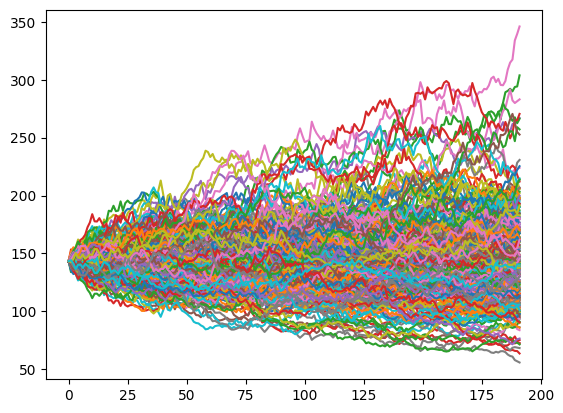

In [15]:
for i in sim_aapl:
    plt.plot(i)
plt.show()

## AMZN

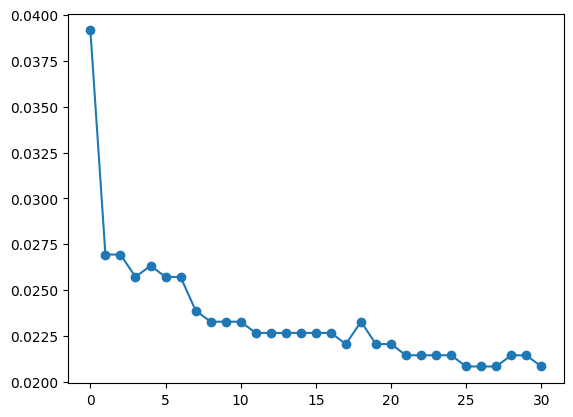

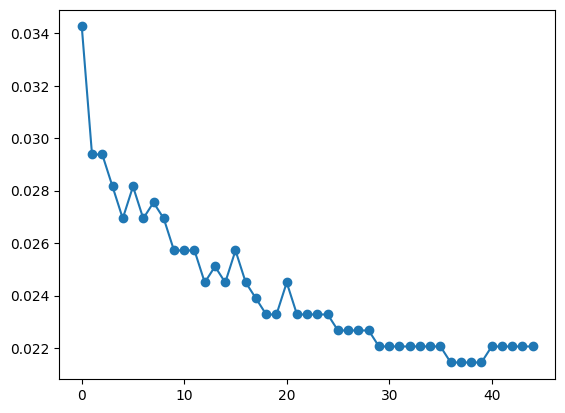

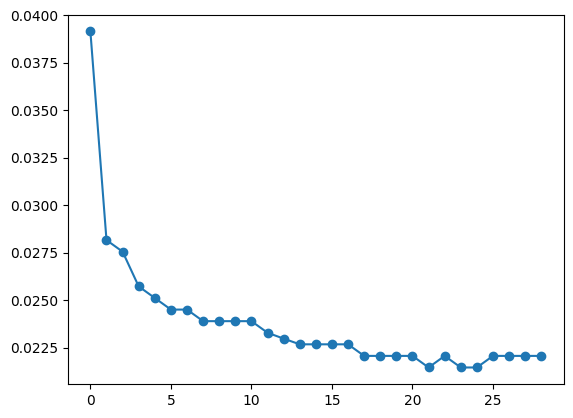

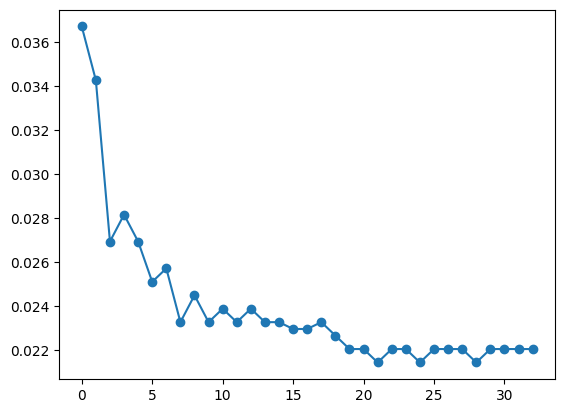

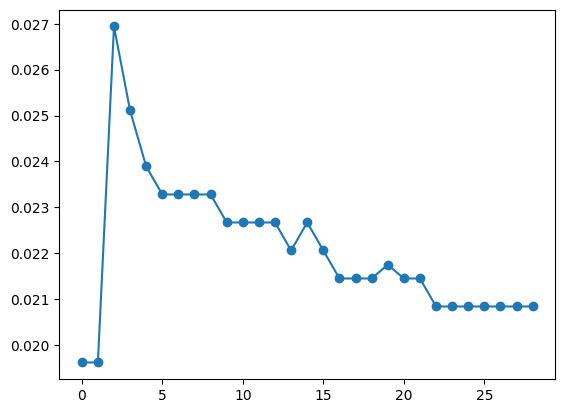

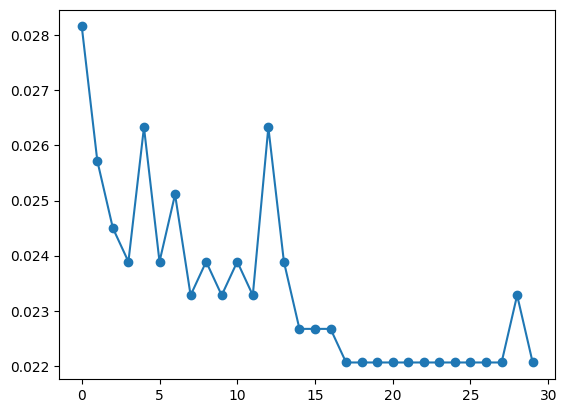

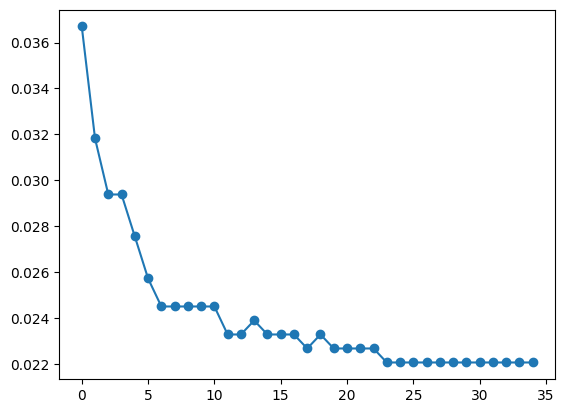

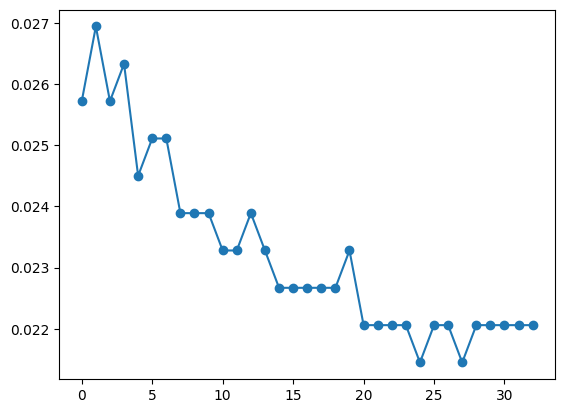

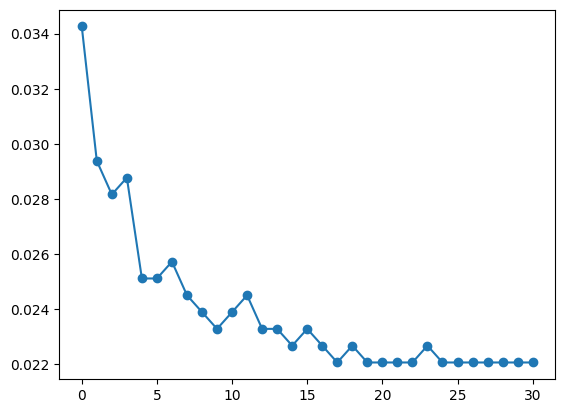

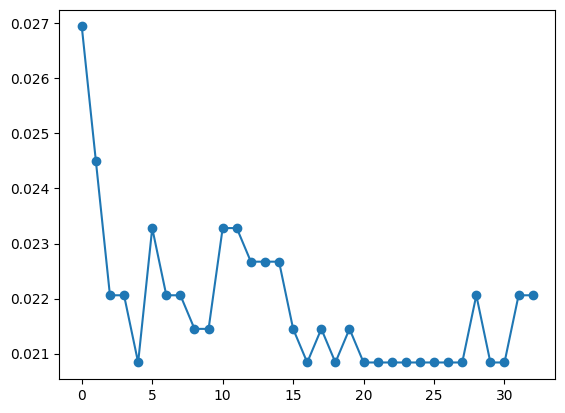

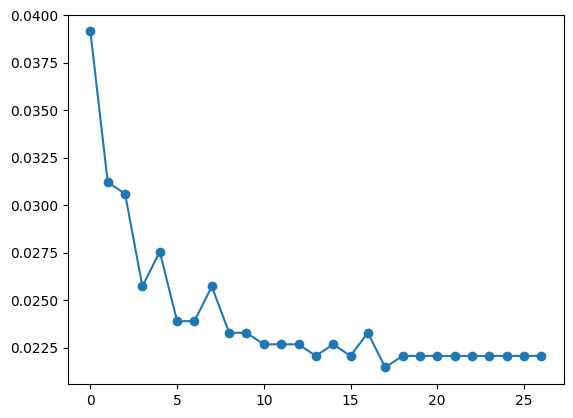

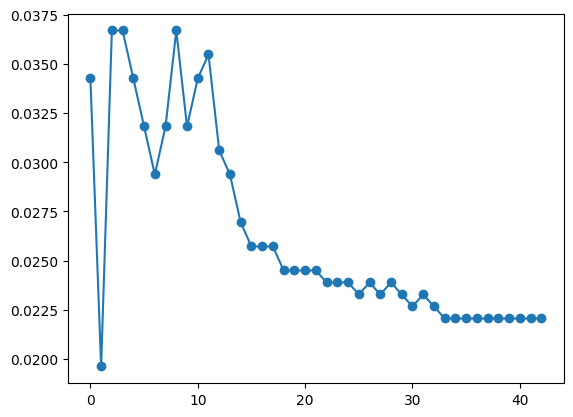

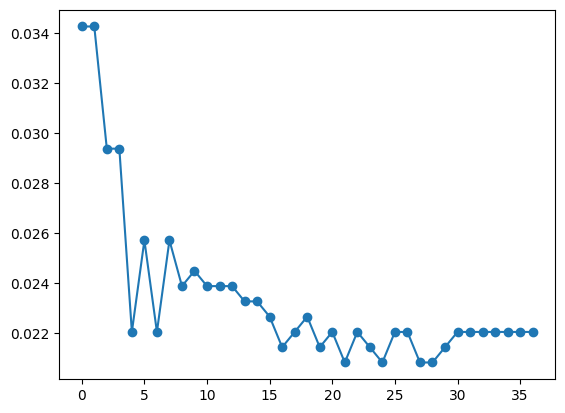

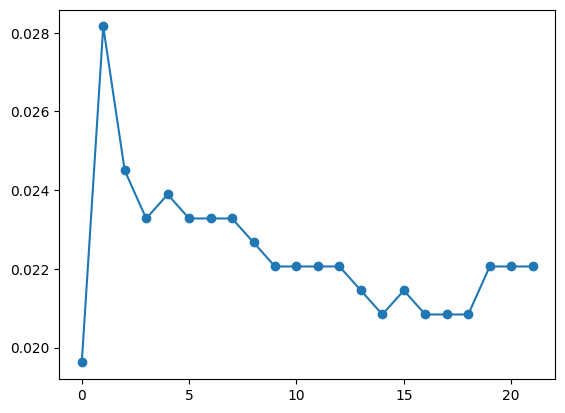

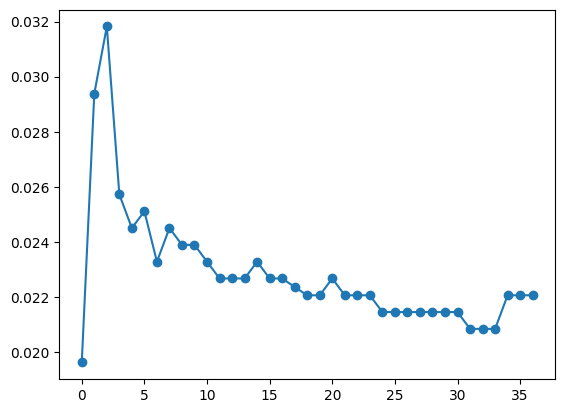

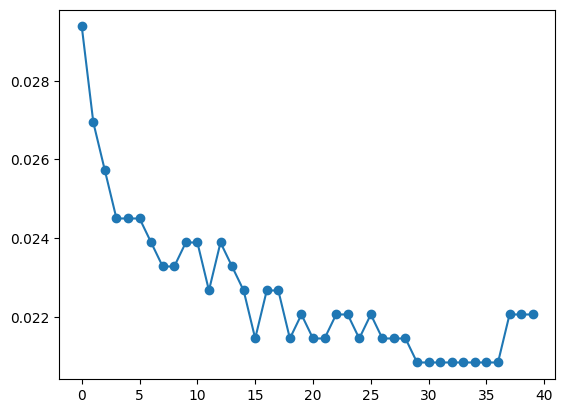

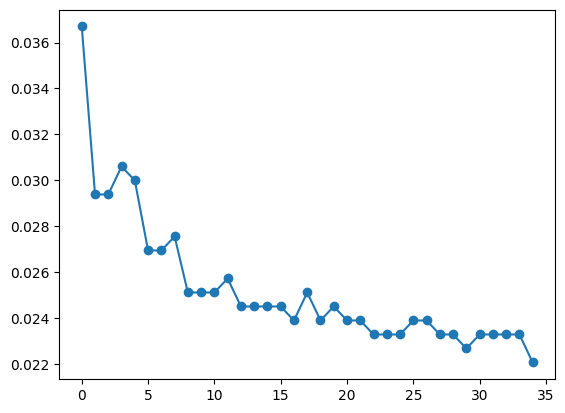

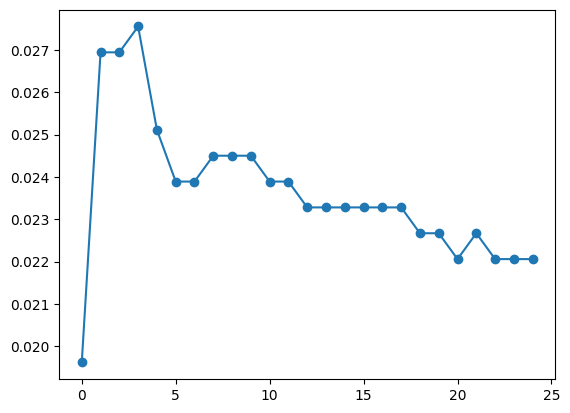

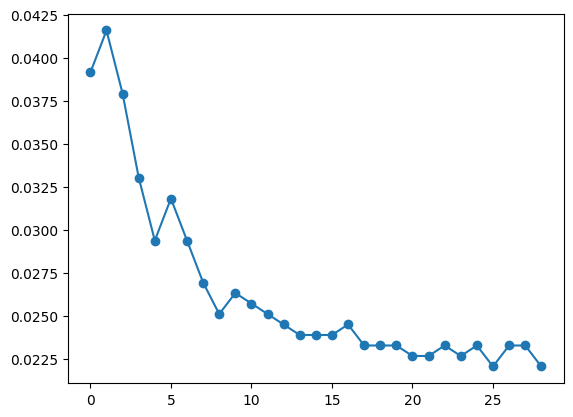

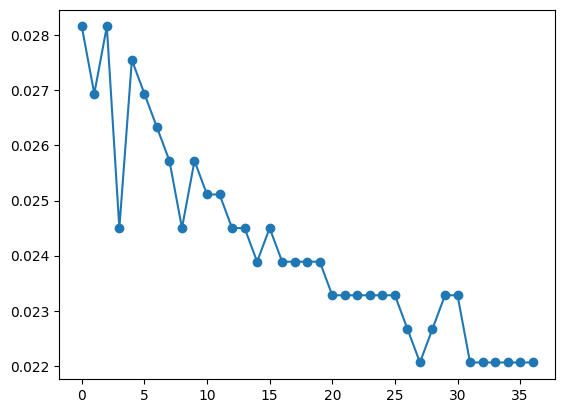

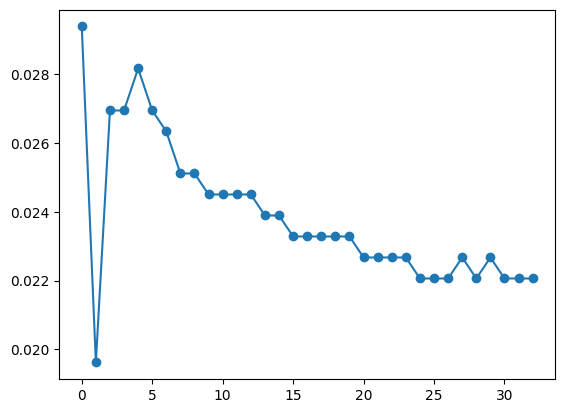

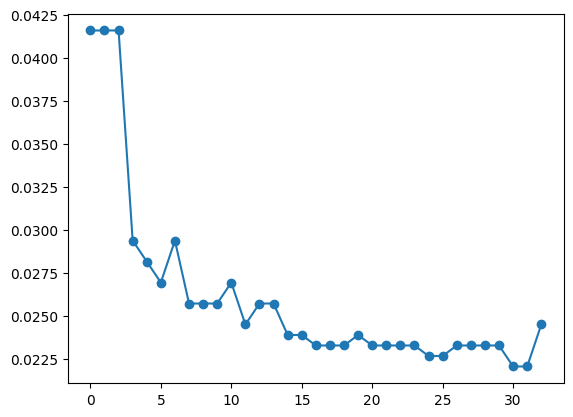

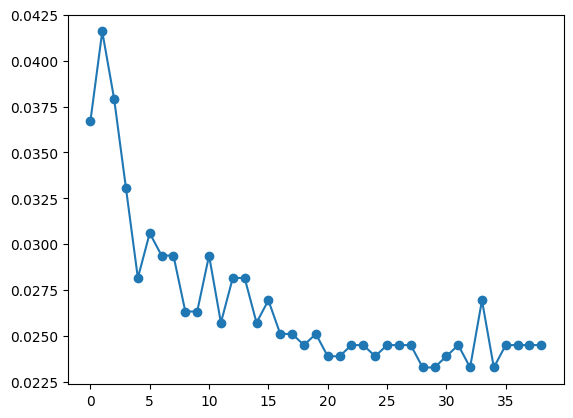

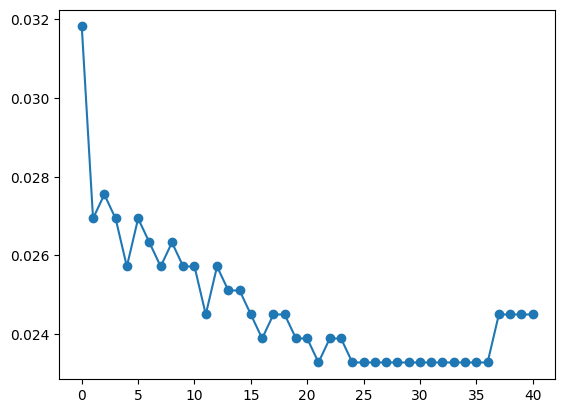

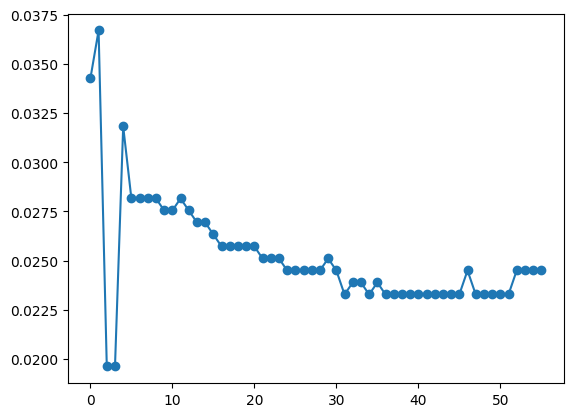

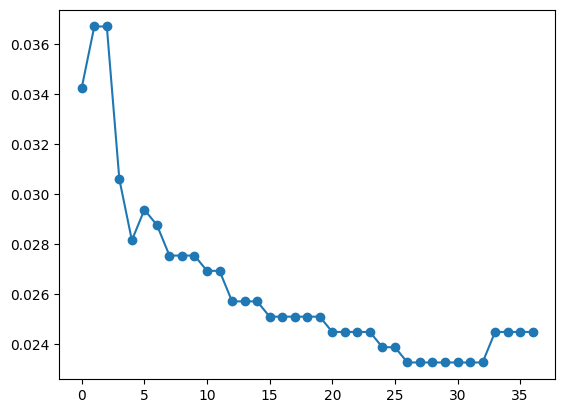

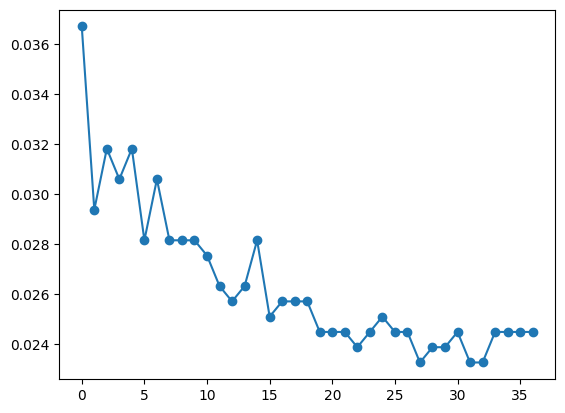

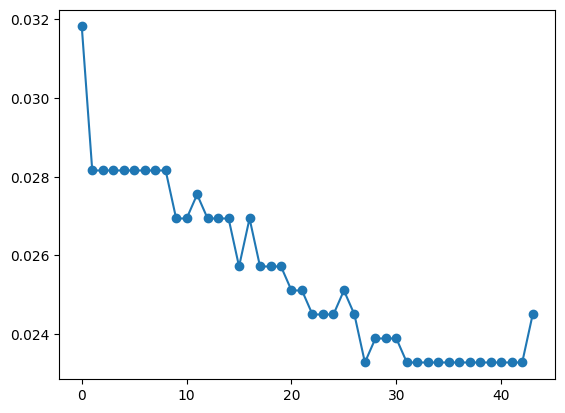

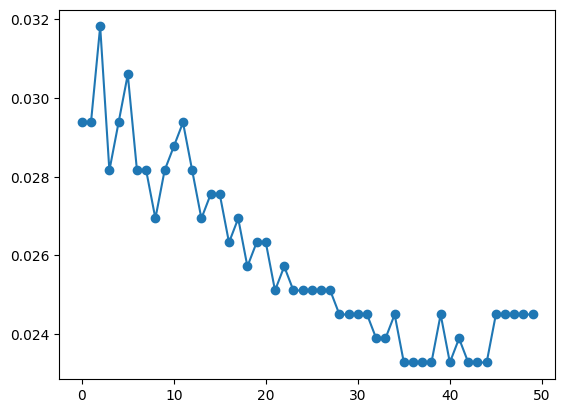

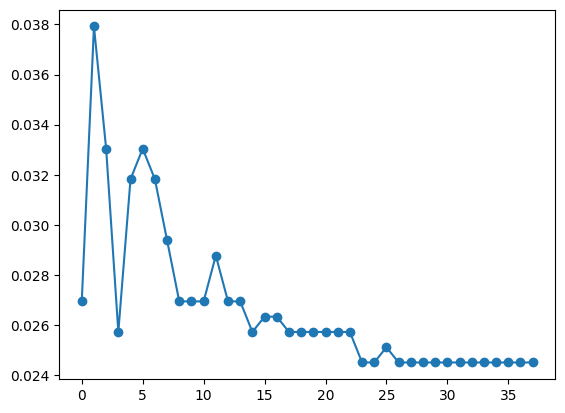

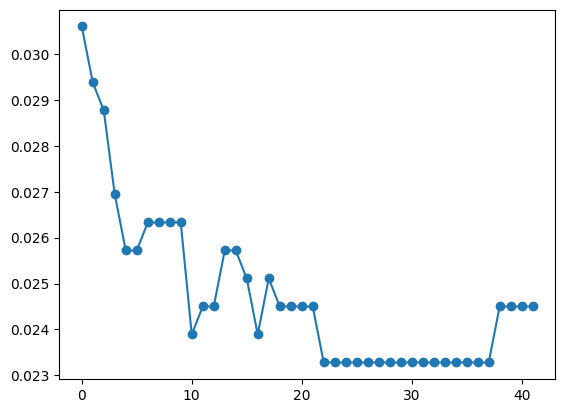

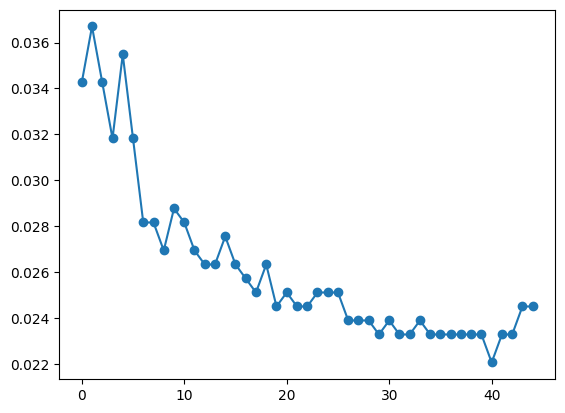

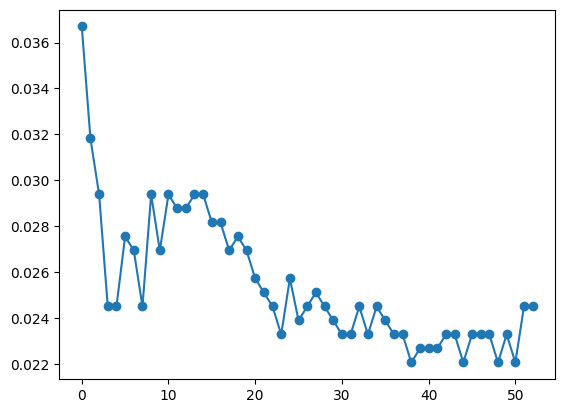

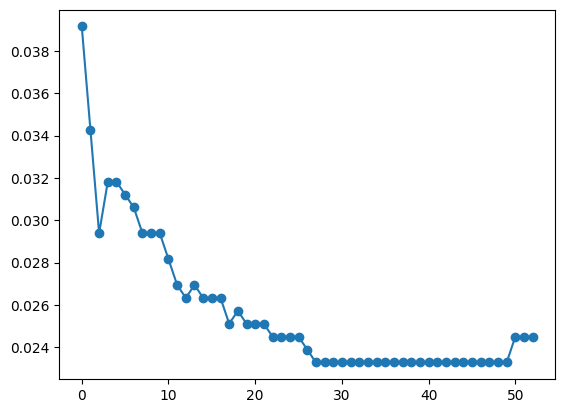

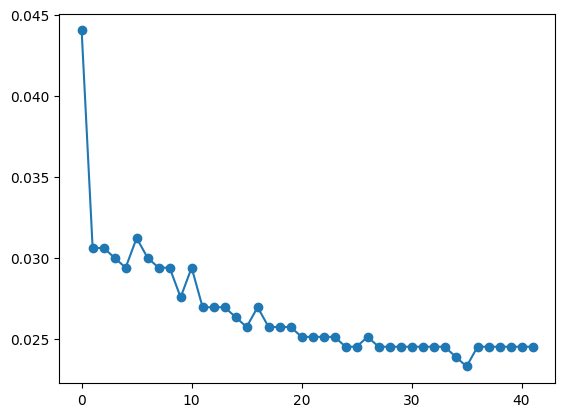

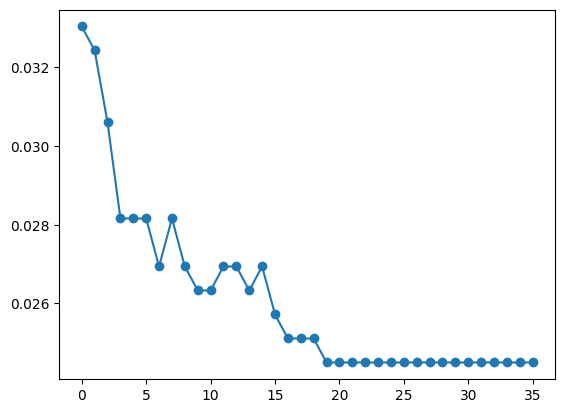

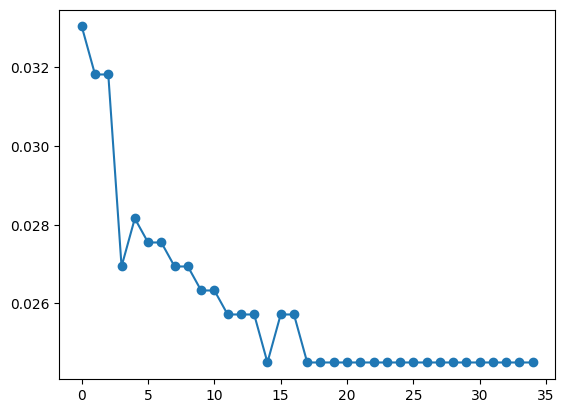

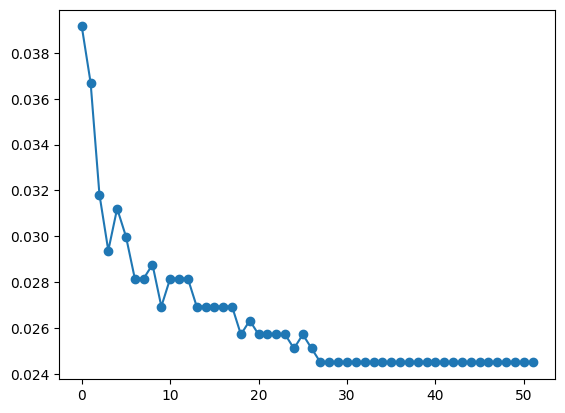

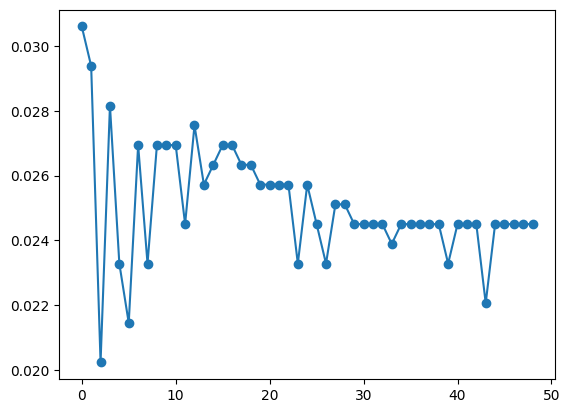

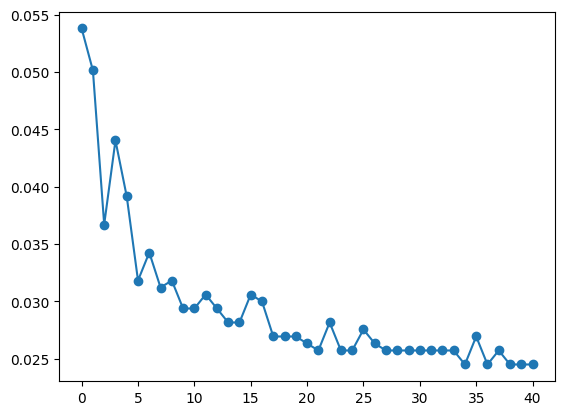

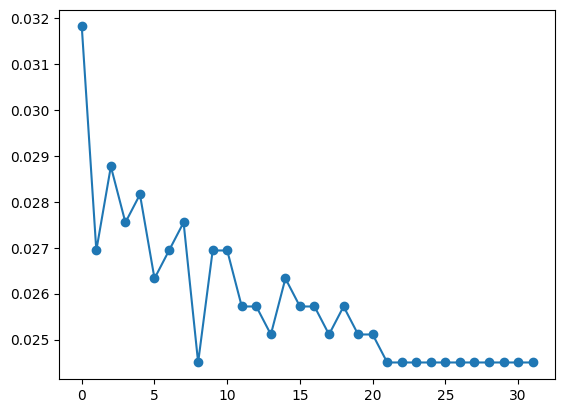

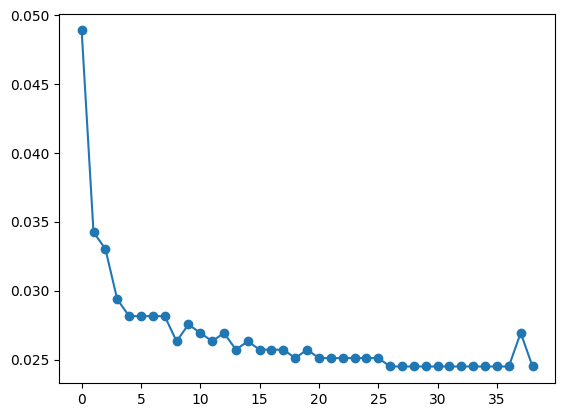

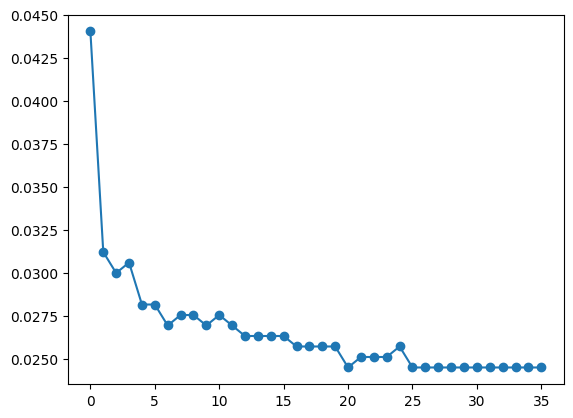

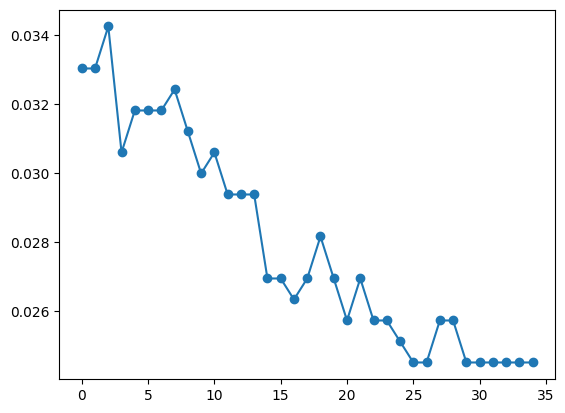

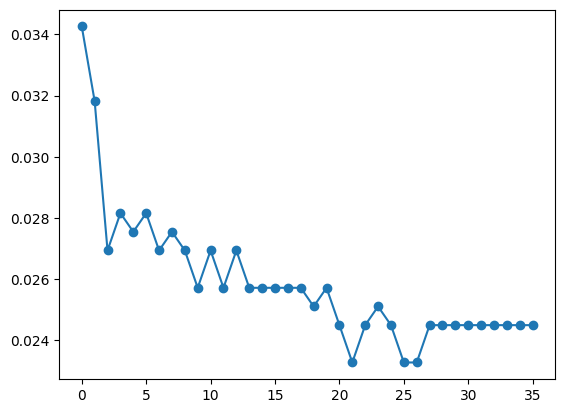

In [7]:
for daily_amzn_IV in amzn_IV_list:
    plt.plot(daily_amzn_IV,**{'marker':'o'})
    plt.show()    

In [8]:
for daily_amzn_IV in amzn_IV_list:
    print(np.mean(daily_amzn_IV))

0.02347709677419354
0.02418822222222222
0.0237955172413793
0.02398212121212121
0.022091379310344817
0.023381666666666655
0.024133999999999992
0.023243030303030297
0.023929354838709664
0.02187515151515151
0.024161481481481475
0.02635837209302325
0.02347783783783783
0.022392727272727262
0.022859459459459452
0.022608999999999997
0.025249428571428565
0.023645999999999993
0.02645689655172413
0.02415378378378378
0.023853030303030296
0.02607212121212121
0.026768205128205116
0.02470829268292683
0.02520803571428571
0.026231081081081076
0.026379459459459454
0.025484318181818177
0.025878599999999995
0.026683157894736836
0.024746904761904758
0.026126666666666663
0.025397735849056597
0.02567415094339622
0.026635238095238094
0.026109722222222218
0.025929142857142855
0.026400576923076916
0.025109999999999993
0.029514878048780484
0.025853437499999996
0.026768205128205123
0.026635277777777768
0.027933428571428567
0.02588944444444444


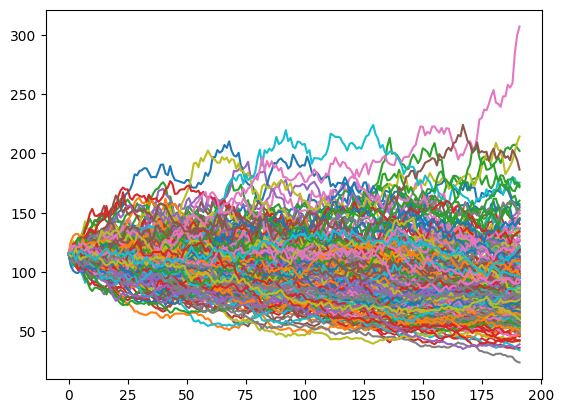

In [16]:
for i in sim_amzn:
    plt.plot(i)
plt.show()

## GOOGL

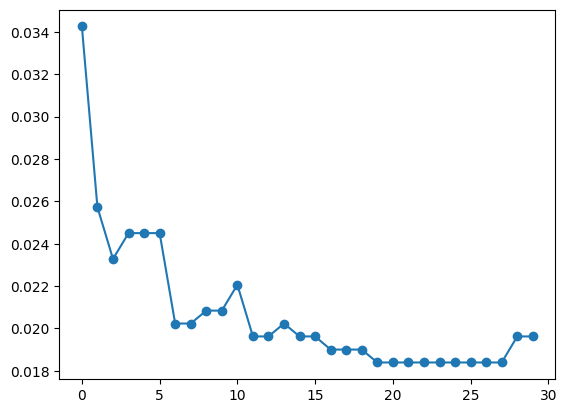

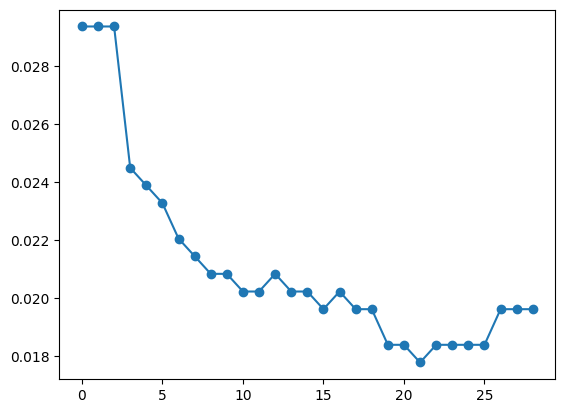

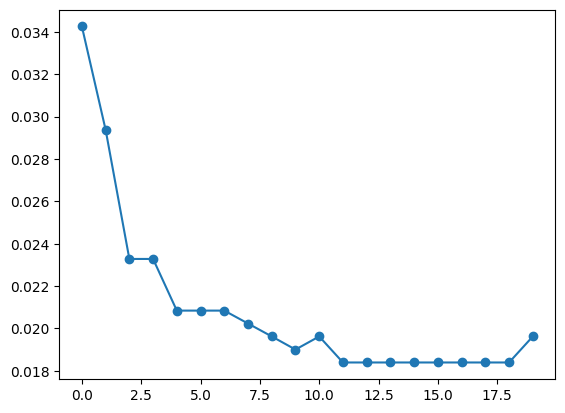

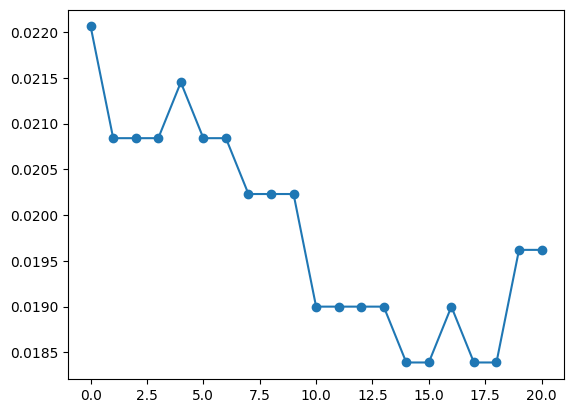

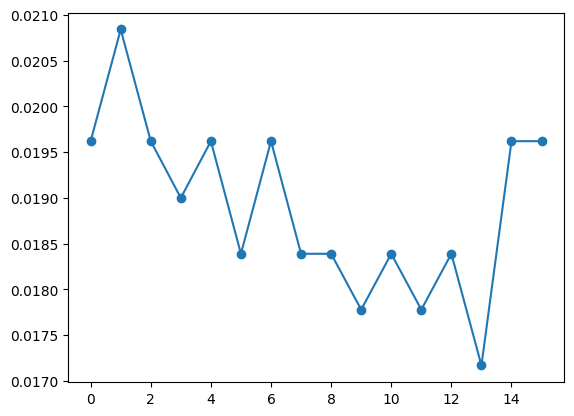

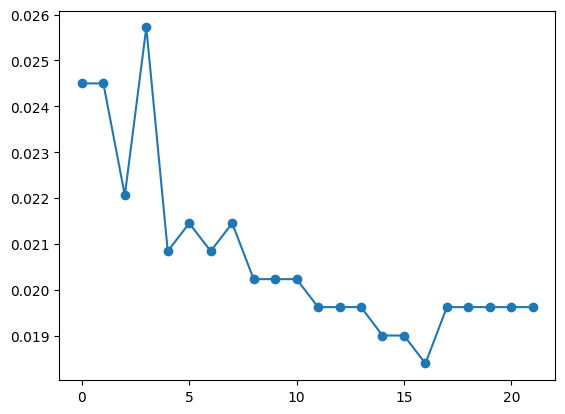

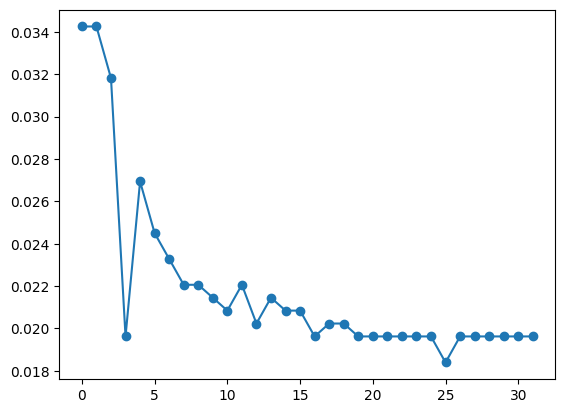

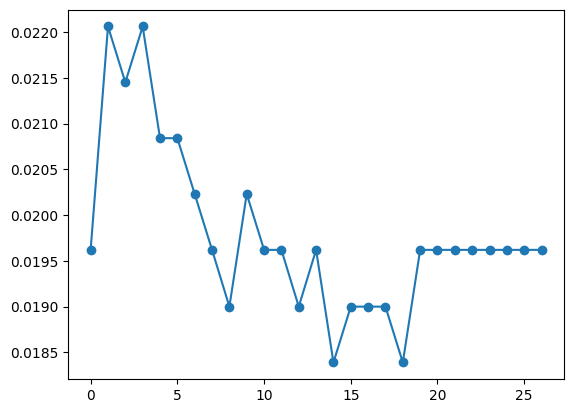

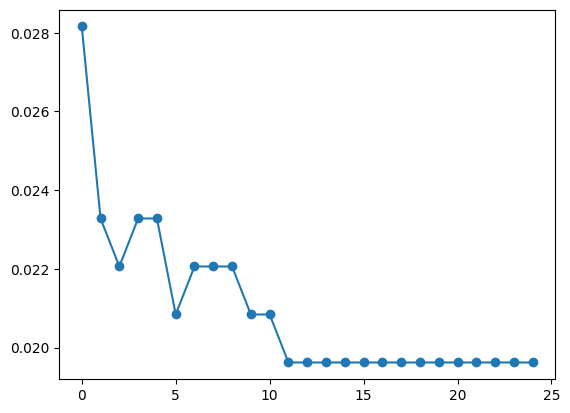

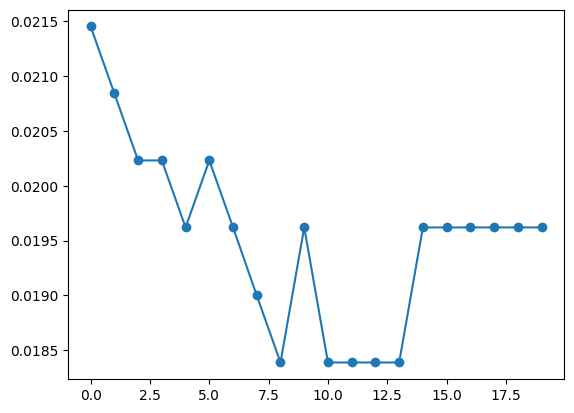

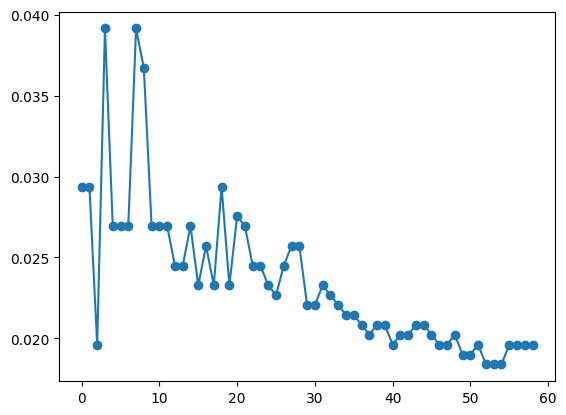

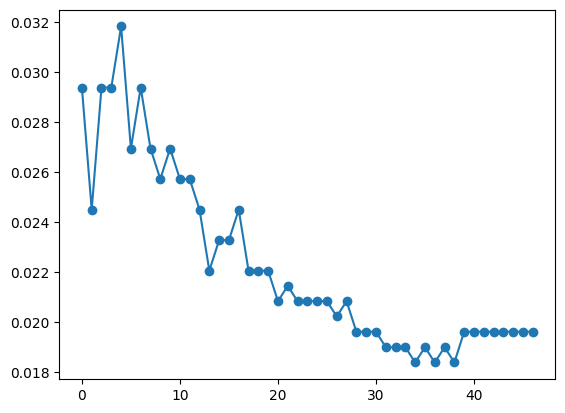

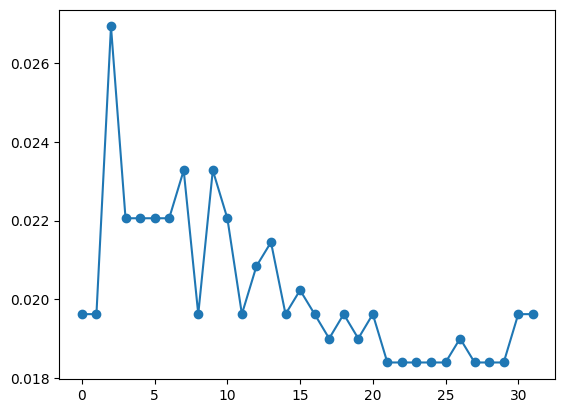

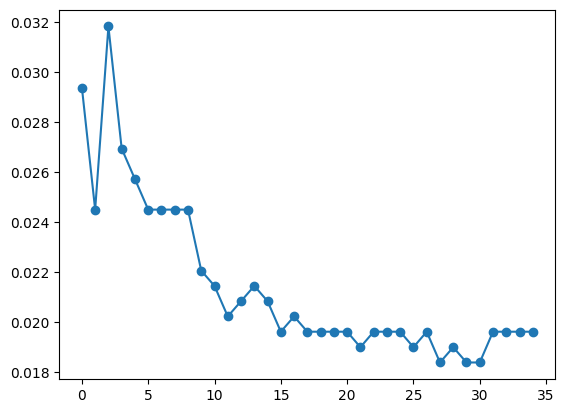

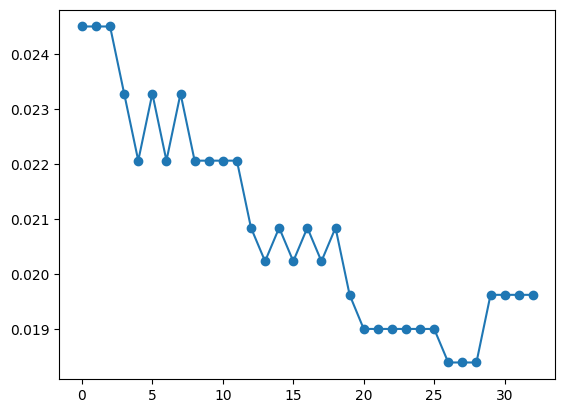

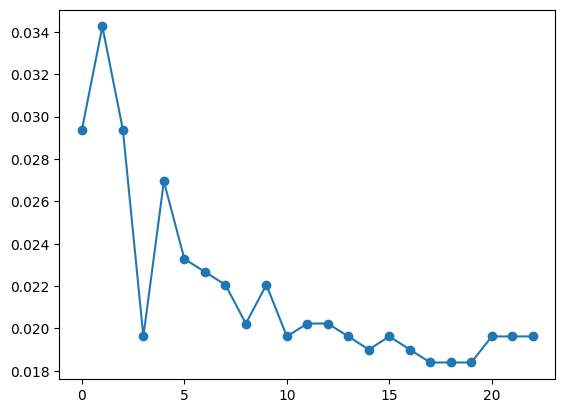

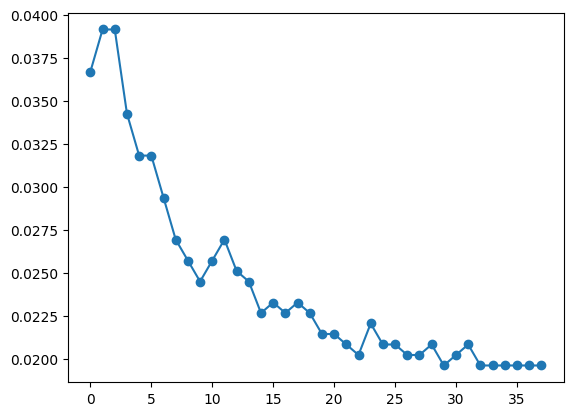

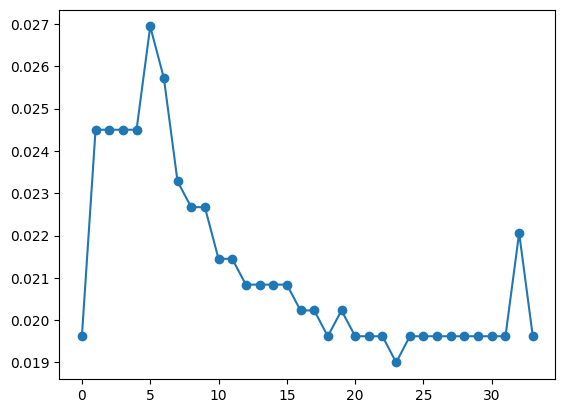

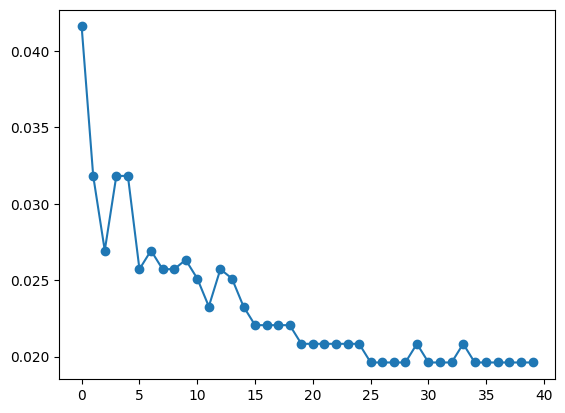

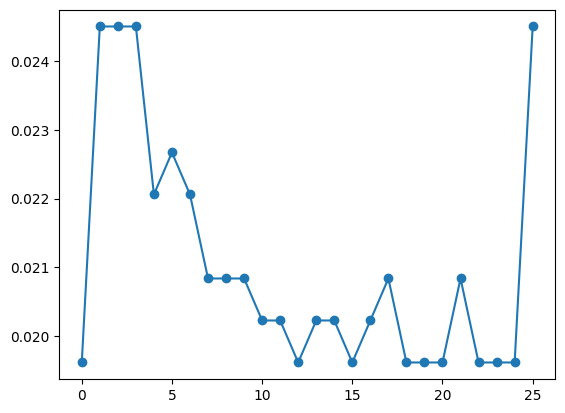

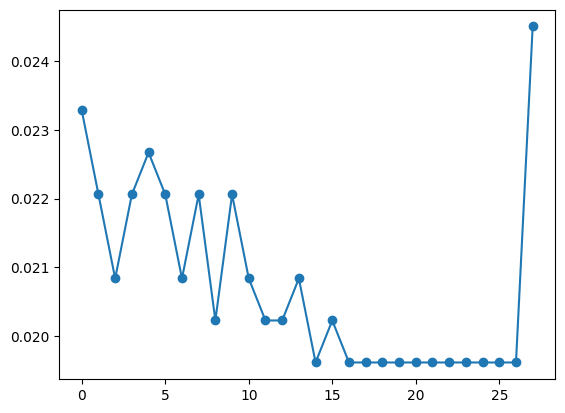

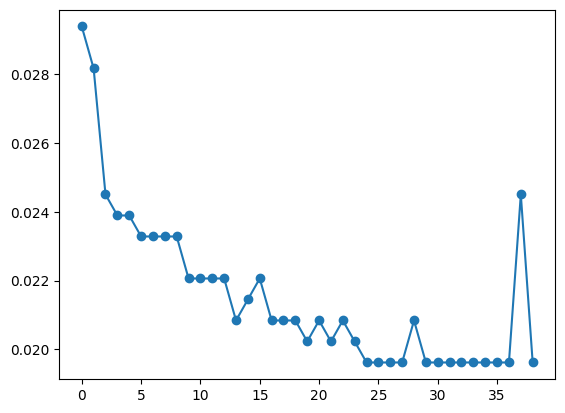

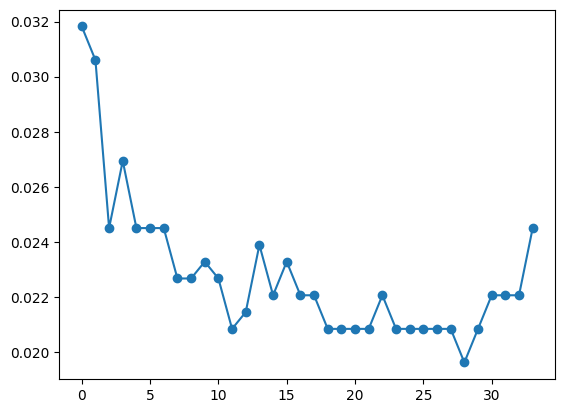

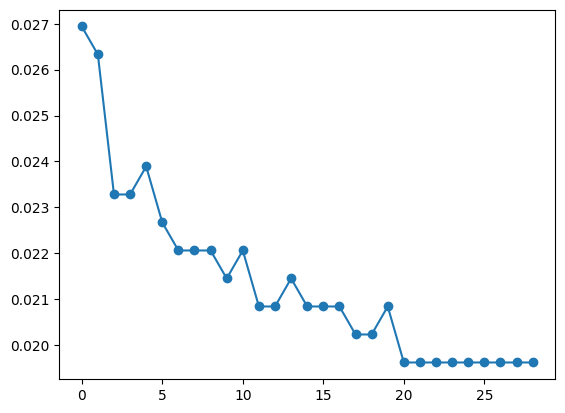

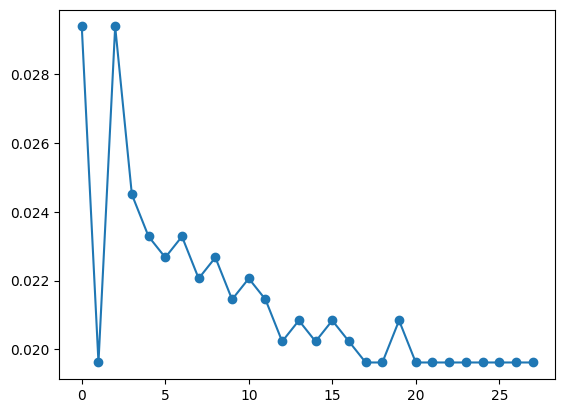

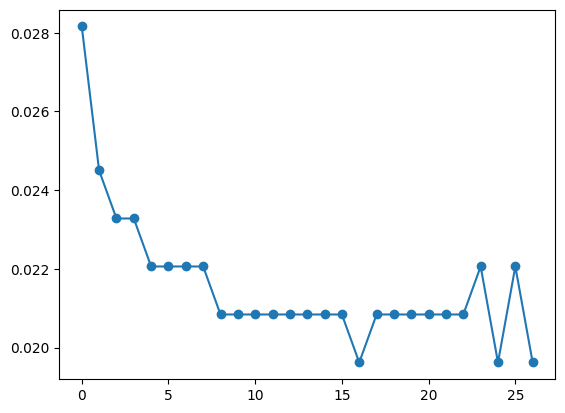

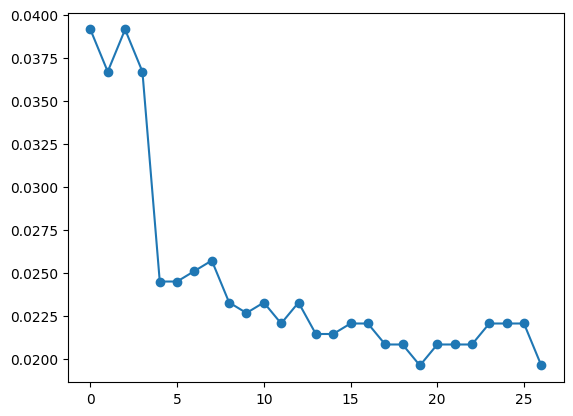

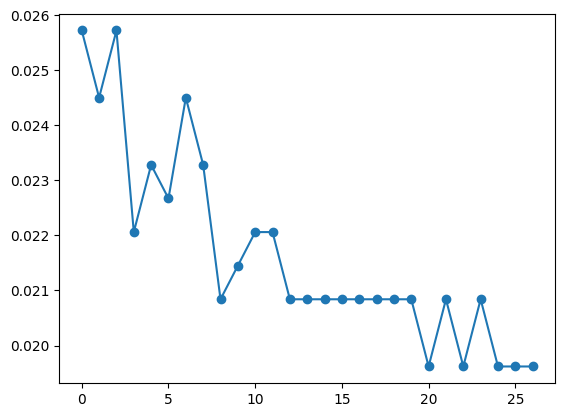

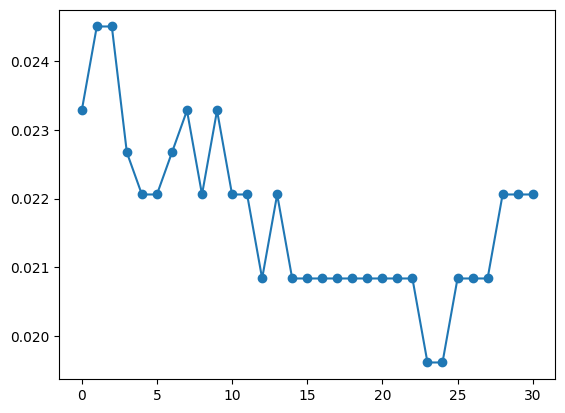

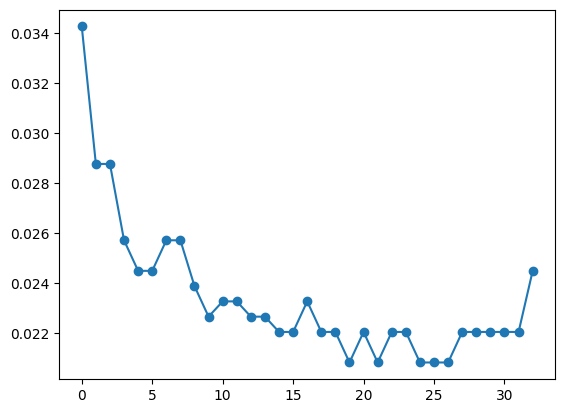

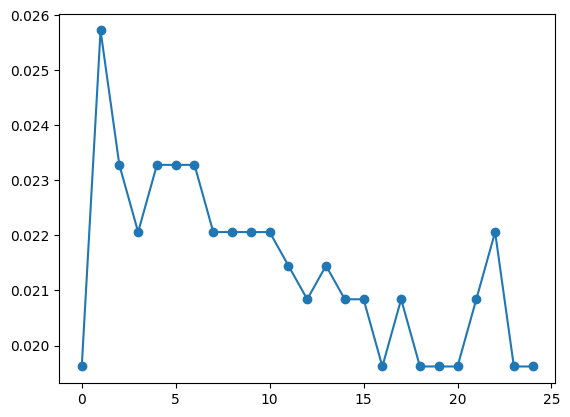

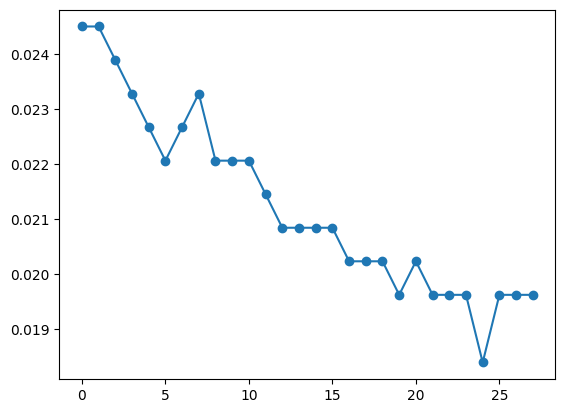

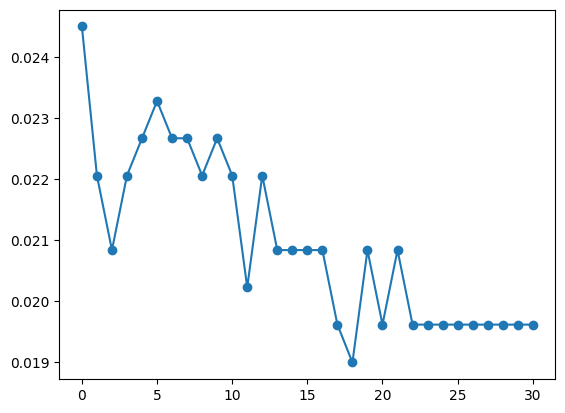

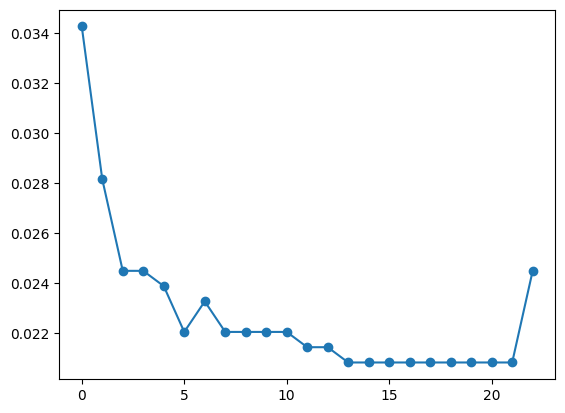

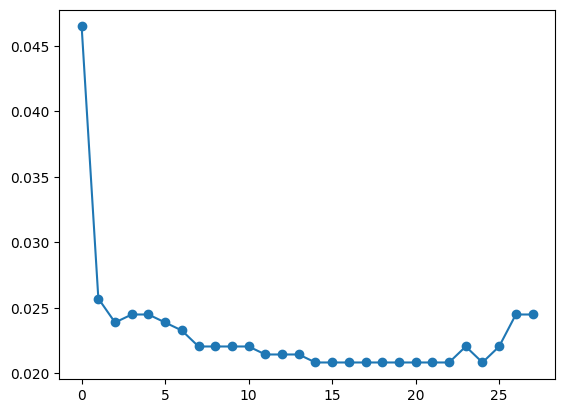

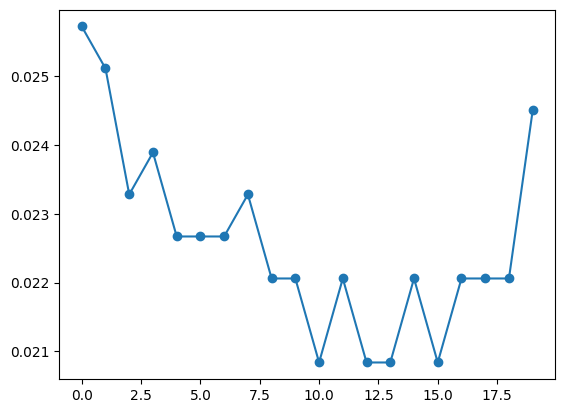

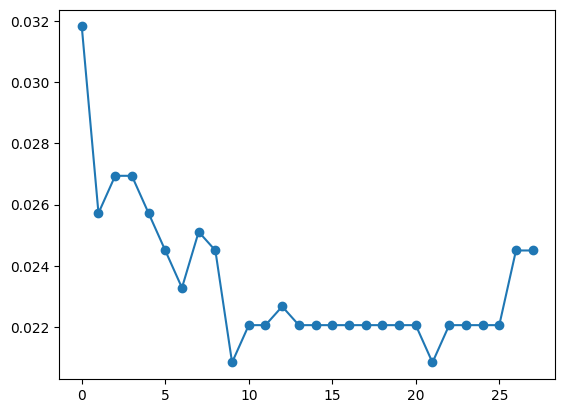

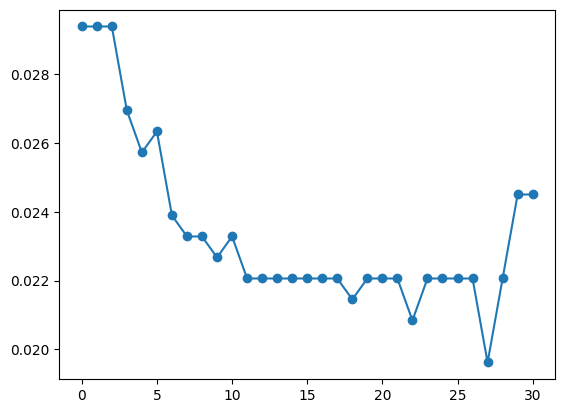

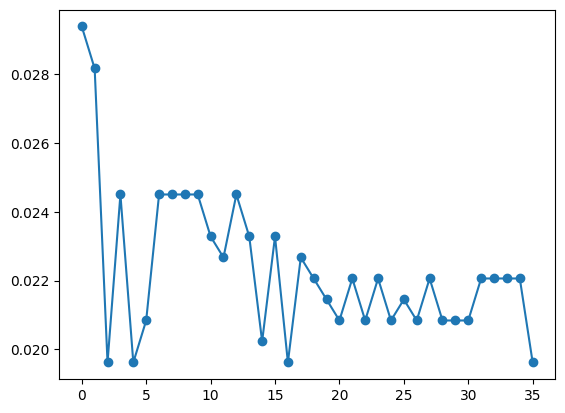

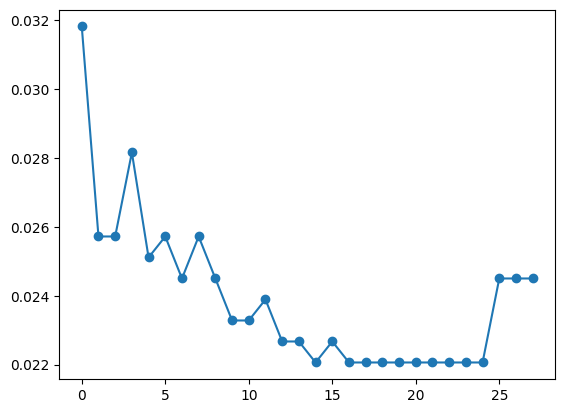

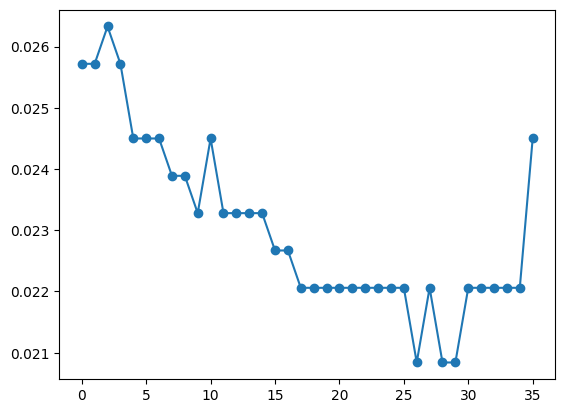

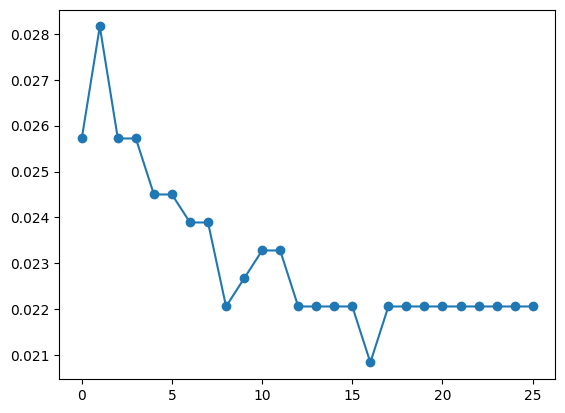

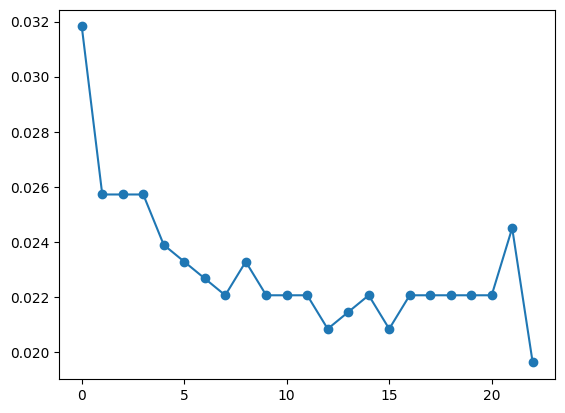

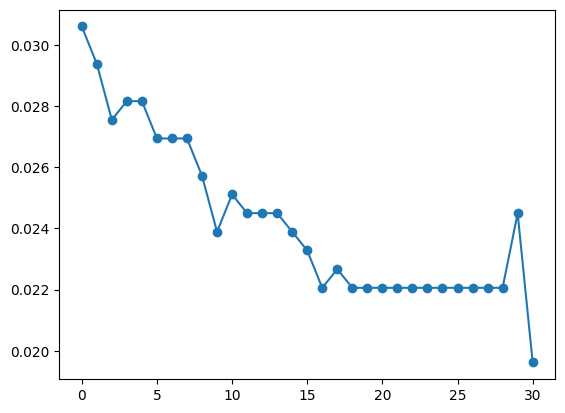

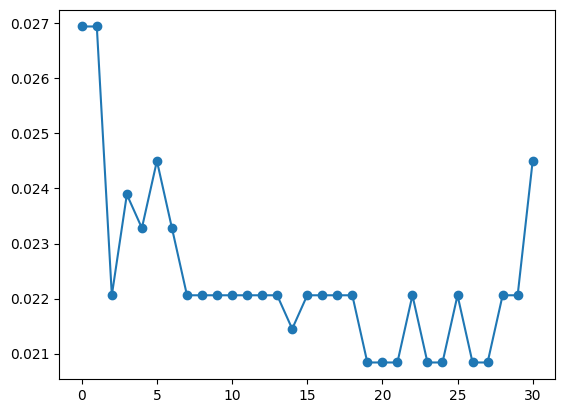

In [8]:
for daily_googl_IV in googl_IV_list:
    plt.plot(daily_googl_IV,**{'marker':'o'})
    plt.show()

In [9]:
for daily_googl_IV in googl_IV_list:
    print(np.mean(daily_googl_IV))

0.020713999999999996
0.021132068965517233
0.020896500000000002
0.019819047619047615
0.018889999999999997
0.020699999999999993
0.021888124999999998
0.019798148148148145
0.020937599999999997
0.01952549999999999
0.023589661016949145
0.02230489361702127
0.020207499999999996
0.021448285714285708
0.02081878787878787
0.021792608695652173
0.024307894736842098
0.021234411764705877
0.023173499999999996
0.021027692307692303
0.02073107142857142
0.02155948717948717
0.022795588235294113
0.02136586206896551
0.021471785714285707
0.021562962962962957
0.024545925925925922
0.021653333333333327
0.021705806451612894
0.023427878787878782
0.021425599999999996
0.02123178571428571
0.02095774193548386
0.022776086956521727
0.023084285714285706
0.022578499999999994
0.023454285714285705
0.02339806451612902
0.022348055555555548
0.023911785714285705
0.023025833333333325
0.023115769230769224
0.023041304347826076
0.02424419354838709
0.022374838709677408


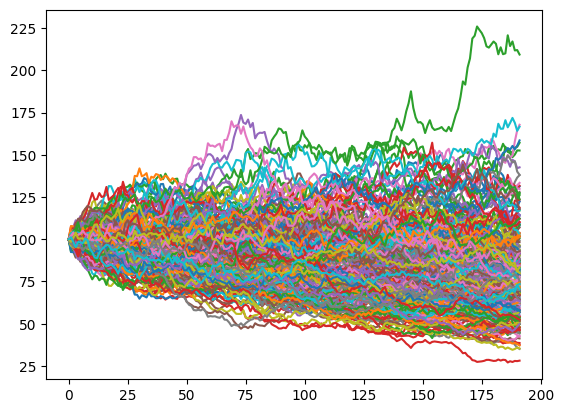

In [17]:
for i in sim_googl:
    plt.plot(i)
plt.show()